# Link between free space and 3-points efficiency

After modelling both model of space occupation and comparing them, we focus on the correlation between space occupation and 3-point performance. To do so, we browse all the games we have, we track when there are 3-point shots and then memorize the evolution of pressure on the shooter 3 seconds before he shots. The algorithm is not presented here, but is available as a python file : track_shoot.py.

Here we extract the informations we want from the data we collected. 

## Data import
-----

The shots are memorized in python dictionnary called Shots. There is also Shots_curry which corresponds to Curry 3-points attempts. It is composed of four keys :
* D_CLOSEST_DEF : a list of list. Each list corresponds to a shot and has two elements. The first one is 0 or 1 : if it is 1 it means that the shot was a success and if it is 0 the shot was missed. The second element is the evolution of the shooter's *free space* ($\delta_{space}^*$ distance to the closest defender) 3 seconds before the shot. 
* T_CLOSEST_DEF : It the same but *free space* is calculated as the time (in second) needed by the closest defender to join the position of the shooter ($\delta_{time}^*$). 
* TIME_TO_SHOOT : a list of list. Each list has two elements : the first one for the result of the shot and the second one corresponds to the time between the reception of the ball and the shot. It is negative : -2 means that the shooter kept the ball 2 seconds before shooting.
* TIME_ABSCISSE : a list of list. Each list corresponds to a shot and has two elements. The first one is 0 or 1 : if it is 1 it means that the shot was a success and if it is 0 the shot was missed. The second element corresponds to time values linked to pressure evolution.


In [1]:
import pickle
dico=pickle.load(open('data/Shots','rb'))
print(dico.keys())
print('number of shots :', len(dico['D_CLOSEST_DEF']))

dict_keys(['D_CLOSEST_DEF', 'T_CLOSEST_DEF', 'TIME_TO_SHOOT', 'TIME_ABSCISSE'])
number of shots : 27201


## *Free space* evolution before a 3-point shot
------

### Global evolution

First we compute a function that restructured the data. Then we compute a function to plot the evolution of *free space* averaged on all the shots. Let's note that we round the values of time with a precision of 0.01 second. Yet the precision of position data is only 0.04 seconds. 

Let's note that we delet some shots because the values of time are wrong : the clock stops but the evolution continue to be captured therefore, if we don't do that, we have false values for a certain value of time.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def restructure_data(data):
    
    ### getting the data ###
    D_CLOSEST_PLAYER=data['D_CLOSEST_DEF']
    T_CLOSEST_PLAYER=data['T_CLOSEST_DEF']
    TIME=data['TIME_ABSCISSE']
    TIME_TO_SHOOT=data['TIME_TO_SHOOT']
    
    ### only the second column because the first one contains if it is a succes or a miss ###
    D_CLOSEST_PLAYER_bis=[]
    T_CLOSEST_PLAYER_bis=[]
    TIME_bis=[]
    TIME_TO_SHOOT_bis=[]
    SUCCESS=[]
    nb_catch_and_shoot=0
    nb_pull_up=0
    nb_success=0
    nb_missed=0
    nb_cns_success=0
    nb_cns_missed=0
    nb_pull_up_success=0
    nb_pull_up_missed=0
    for k in range(len(D_CLOSEST_PLAYER)):
        unique,count=np.unique(np.array(TIME[k][1]).round(2), return_counts=True)
        if list(count)==[1]*len(count): # we don't take shots where values of time are repeated, because in the data, sometimes the values of time doesn't change so stay on the same second but we count the evolution on this second
            if D_CLOSEST_PLAYER[k][0]==0:
                nb_missed+=1
                if TIME_TO_SHOOT[k][1]>-2:
                    nb_catch_and_shoot+=1
                    nb_cns_missed+=1
                else :
                    nb_pull_up+=1
                    nb_pull_up_missed+=1
            else :
                nb_success+=1
                if TIME_TO_SHOOT[k][1]>-2:
                    nb_catch_and_shoot+=1
                    nb_cns_success+=1
                else :
                    nb_pull_up+=1
                    nb_pull_up_success+=1
            D_CLOSEST_PLAYER_bis.append(D_CLOSEST_PLAYER[k][1])
            T_CLOSEST_PLAYER_bis.append(T_CLOSEST_PLAYER[k][1])
            TIME_bis.append(np.array(TIME[k][1]).round(2)) # round to 0.01 second
            TIME_TO_SHOOT_bis.append([TIME_TO_SHOOT[k][1]]*len(TIME[k][1]))
            SUCCESS.append([TIME_TO_SHOOT[k][0]]*len(TIME[k][1]))
    
    print('number of valid shot:',len(D_CLOSEST_PLAYER_bis))
    print('number of success :',nb_success)
    print('number of miss :',nb_missed)
    print('percentage of success:',nb_success/(nb_success+nb_missed)*100)
    print('percentage of catch-and-shoot shots :',nb_catch_and_shoot/(nb_pull_up+nb_catch_and_shoot)*100)
    print('percentage of catch-and-shoot success:',nb_cns_success/(nb_cns_missed+nb_cns_success)*100)
    print('percentage of pull-up success:',nb_pull_up_success/(nb_pull_up_missed+nb_pull_up_success)*100)
    
    ### we concatenate all the data
    TIME_bis=np.concatenate(np.array(TIME_bis)) 
    D_CLOSEST_PLAYER_bis=np.concatenate(np.array(D_CLOSEST_PLAYER_bis))
    T_CLOSEST_PLAYER_bis=np.concatenate(np.array(T_CLOSEST_PLAYER_bis))
    TIME_TO_SHOOT_bis=np.concatenate(np.array(TIME_TO_SHOOT_bis))
    SUCCESS=np.concatenate(np.array(SUCCESS))
    
    ### put the data into a dataframe ###
    df=pd.DataFrame({'D':D_CLOSEST_PLAYER_bis,'T':T_CLOSEST_PLAYER_bis,'Time':TIME_bis,'Time_to_shoot':TIME_TO_SHOOT_bis,'Shot result':SUCCESS})
    
    ## only evolution between 3.2 seconds before shot and 0.8 second after. (It is because there are some errors in the data) ##
    df=df.query('Time>-3.2 and Time<0.8').copy()
    
    return(df)

def averaged_evolution(df,sd=None,hue=None,palette=['blue'],style=None,fontsize='medium'):
    
    ## rename columns to have good labels ##
    df2=df.rename(columns={"Time": "time [s]",'D':r'$<\delta_{d}^*(t)$> [feet]','T':r'$<\delta_{t}^*(t)$> [s]'})
    
    ### plot ###
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{d}^*(t)$> [feet]', data=df2,palette=palette,ci=sd,hue=hue,style=style)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize=fontsize)
    plt.show()
    plt.clf()
   
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{t}^*(t)$> [s]', data=df2,palette=palette,ci=sd,hue=hue,style=style)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize=fontsize)
    plt.show()
    plt.clf()

number of valid shot: 26325
number of success : 9132
number of miss : 17193
percentage of success: 34.68945868945869
percentage of catch-and-shoot shots : 78.86799620132953
percentage of catch-and-shoot success: 35.84433098930739
percentage of pull-up success: 30.379291749056264


/Users/gabin/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


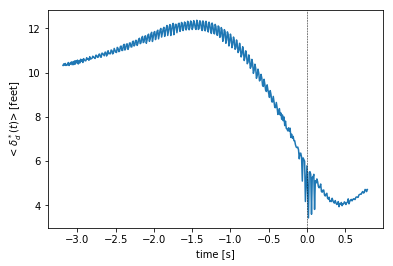

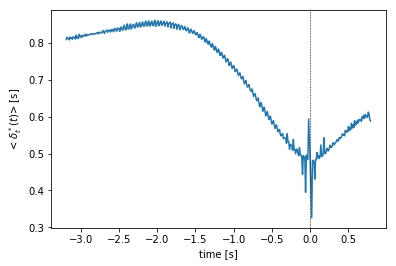

In [10]:
df=restructure_data(dico)
averaged_evolution(df)

We see that there is some noise. To calculate the plot sns.lineplot take each value of time and make a mean over all the pressure value associated. If we count the number of pressure values per time value we can see that there isn't an equilibrium as there are more of multiple of 0.04 :

In [5]:
print('count',df.groupby('Time').count())

count            D  Shot result      T  Time_to_shoot
Time                                           
-3.19   3326         3326   3326           3326
-3.18   2830         2830   2830           2830
-3.17   4030         4030   4030           4030
-3.16  14286        14286  14286          14286
-3.15   3576         3576   3576           3576
-3.14   2976         2976   2976           2976
-3.13   4185         4185   4185           4185
-3.12  14404        14404  14404          14404
-3.11   3651         3651   3651           3651
-3.10   3005         3005   3005           3005
-3.09   4217         4217   4217           4217
-3.08  14447        14447  14447          14447
-3.07   3687         3687   3687           3687
-3.06   3052         3052   3052           3052
-3.05   4229         4229   4229           4229
-3.04  14481        14481  14481          14481
-3.03   3706         3706   3706           3706
-3.02   3037         3037   3037           3037
-3.01   4279         4279   4279  

Our aim is to make mean for each value of time over the 26325 shots. To do so, we will aggregate values around multiple of 0.04 seconds with the following function :

In [6]:
def aggregating_04(row):
    number=row['Time']
    q=number//0.04
    if abs(round((q*0.04-number),2))<=0.02:
        return(q*0.04)
    else :
        return((q+1)*0.04)

/Users/gabin/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


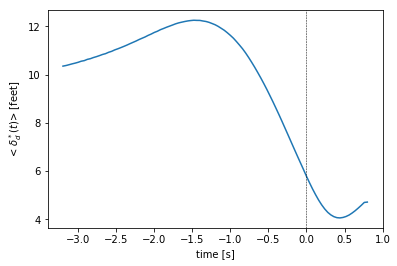

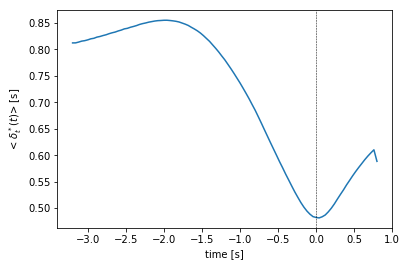

In [7]:
df['Time']=df.apply(aggregating_04,axis=1)
averaged_evolution(df)

The result is better here. Now let's see if we plot the standard deviation :

/Users/gabin/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


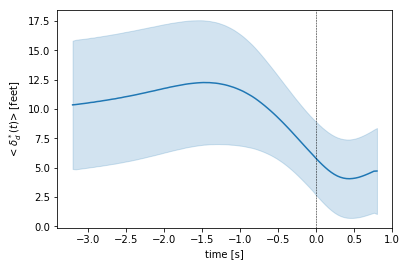

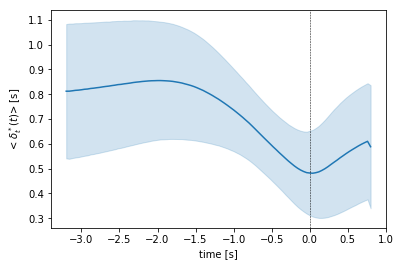

In [12]:
averaged_evolution(df,sd='sd')

### Different types of shots

We distinguish two types of shots :
* catch-and-shoot shot : when a player immediately shot after receiving the ball (2 seconds after)
* pull-up shot : when a player shot after dribbling

In fact some shots can be in neither category : wait more than two seconds without dribbling. But we admit that this is only a small part of shots. Therefore to distinguish both types we look at the value TIME_TO_SHOOT.

We found that there were 78% of catch-and-shoot shots. Yet our games are from 2013 to 2016, according to https://www.thespax.com/nba/three-point-shooting-part-i-the-dying-catch-and-shoot-shot/, there were about 75% of catch-and-shoot shots. Our value is closed to the reality.

In [13]:
def shot_type(row):
    if row['Time_to_shoot']>-2:
        return('catch-and-shoot 3P')
    else :
        return('pull-up 3P')

In [14]:
df['Shot type']=df.apply(shot_type,axis=1)

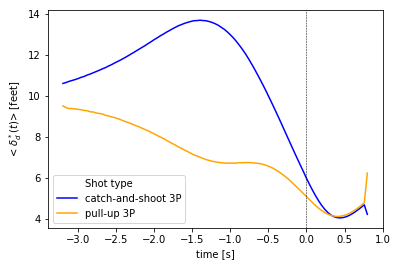

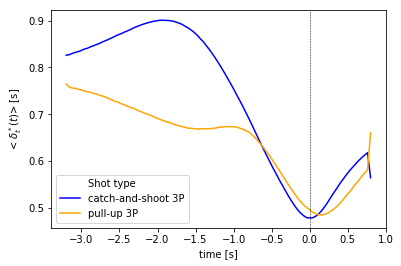

In [15]:
averaged_evolution(df,palette=['blue','orange'],hue='Shot type')

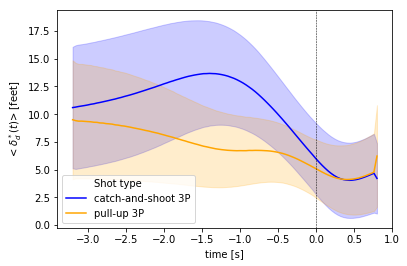

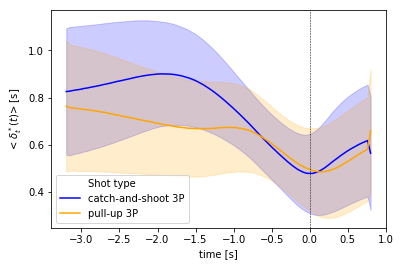

In [16]:
averaged_evolution(df,palette=['blue','orange'],hue='Shot type',sd='sd')

### Difference between success and miss

We want to know if the pressure exerced on a player has an influence on his 3-point performance.

In [17]:
def shot_result(row):
    if row['Shot result']==0:
        return('miss')
    else :
        return('success')

In [18]:
df['Shot result']=df.apply(shot_result,axis=1)

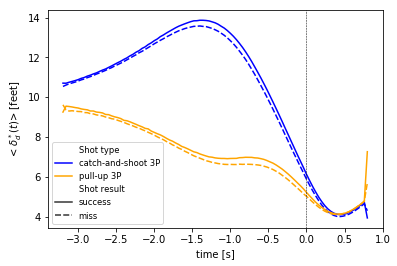

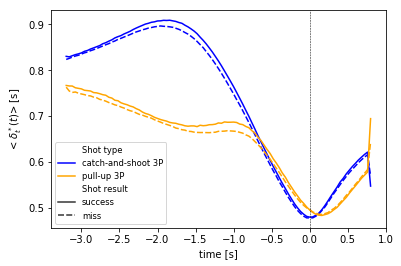

In [19]:
averaged_evolution(df,palette=['blue','orange'],hue='Shot type',style='Shot result',fontsize='small')

### Curry's case

In [21]:
dico_curry=pickle.load(open('data/Shots_curry','rb'))

number of valid shot: 375
number of success : 152
number of miss : 223
percentage of success: 40.53333333333333
percentage of catch-and-shoot shots : 53.333333333333336
percentage of catch-and-shoot success: 42.5
percentage of pull-up success: 38.285714285714285


/Users/gabin/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


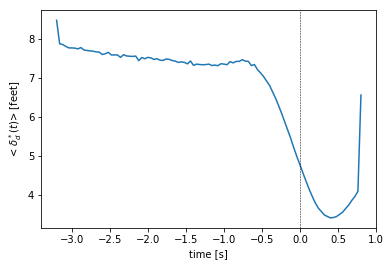

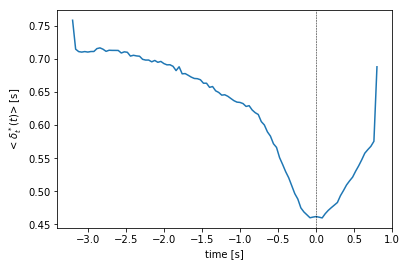

In [22]:
df_curry=restructure_data(dico_curry)
df_curry['Time']=df_curry.apply(aggregating_04,axis=1)
averaged_evolution(df_curry)

/Users/gabin/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


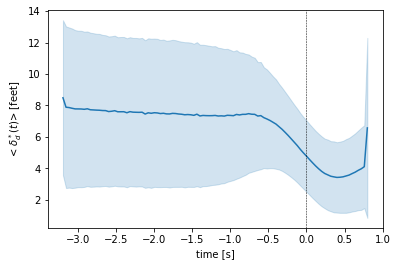

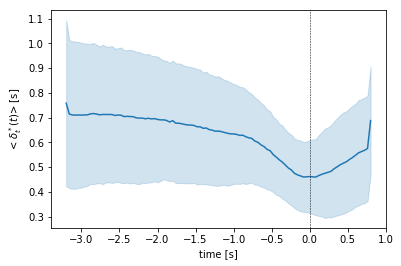

In [23]:
averaged_evolution(df_curry,sd='sd')

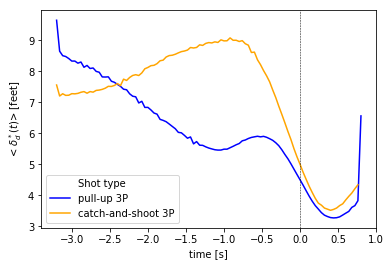

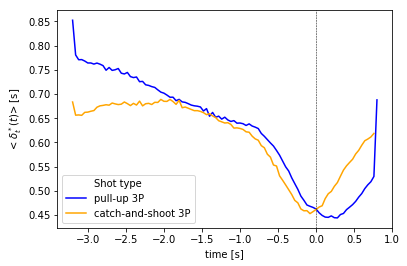

In [24]:
df_curry['Shot type']=df_curry.apply(shot_type,axis=1)
averaged_evolution(df_curry,palette=['blue','orange'],hue='Shot type')

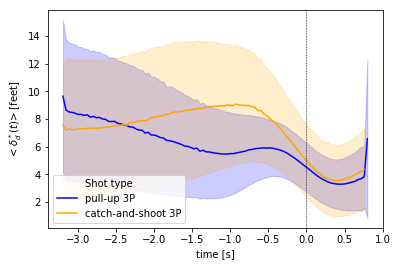

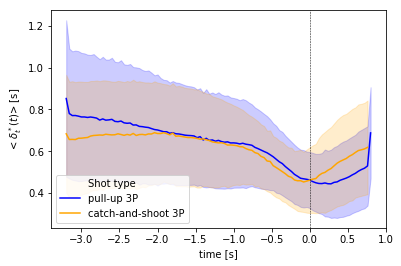

In [25]:
averaged_evolution(df_curry,palette=['blue','orange'],hue='Shot type',sd='sd')

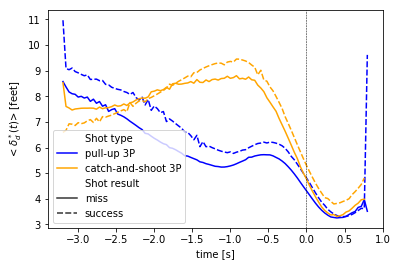

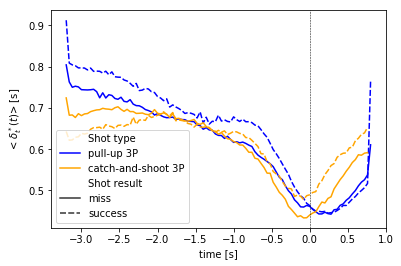

In [26]:
df_curry['Shot result']=df_curry.apply(shot_result,axis=1)
averaged_evolution(df_curry,palette=['blue','orange'],hue='Shot type',style='Shot result')

### Compare Curry to global behaviour

In [31]:
def averaged_evolution(df,df_curry,sd=None,hue=None,palette=['blue'],style=None,size=None):
    
    ## rename columns to have good labels ##
    df2=pd.concat([df,df_curry],ignore_index=True)
    players=['all' for k in range(len(df))]+['Curry' for k in range(len(df_curry))]
    df2['Player']=players
    df2=df2.rename(columns={"Time": "time [s]",'D':r'$<\delta_{d}^*(t)$> [feet]','T':r'$<\delta_{t}^*(t)$> [s]'})
    
    ### plot ###
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{d}^*(t)$> [feet]', data=df2,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize='small')
    plt.show()
    plt.clf()
   
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{t}^*(t)$> [s]', data=df2,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize='small')
    #plt.savefig('Comparison_curry_t',dpi=72)
    plt.show()
    plt.clf()

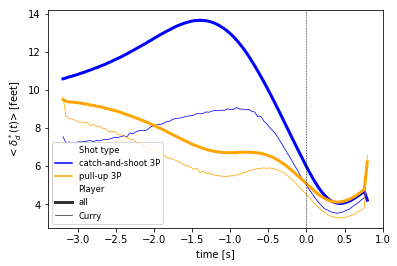

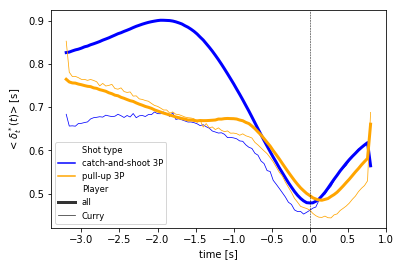

In [32]:
averaged_evolution(df,df_curry,sd=None,hue='Shot type',palette=['blue','orange'],style=None,size='Player')

## *Free space* and 3P performance
------

We want to quantify the following intuition : "the more free a shooter is, the more efficient he is". To do so, we evaluate 3-point efficiency function of the distance (and time) within the opponent defender is. The code is available in python-file/statistics.py.

![](images/efficiency_inferior_d_bis.png)
*Shot efficiency as a function of maximum available space $\delta_d^*$ at the release-time of the ball. If the closest defender is within 4 feet, the shooting percentage is 26,3\%, while it goes to 33,6\% if he is within 8 feet.*

![Shot efficiency as a function of maximum available time $\delta_t^*$ (free space) at the release of the ball. Around $t=0.5s$ a significant change in behaviour is observed.](images/efficiency_inferior_t_bis.png)